In [81]:
import pickle
import re, os   
import numpy as np 
import pandas as pd
import seaborn as sns     
import tensorflow as tf   
import matplotlib.pyplot as plt

from nltk import word_tokenize
from wordcloud import WordCloud
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.preprocessing import LabelEncoder

np.random.seed(1234)
tf.random.set_seed(1234)

print('Tensorflow version : ', tf.__version__)

Tensorflow version :  2.10.0


# Review Sentiment Model

In [82]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for i in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)
    print("Consuming GPU for Training.") 
    
else:
    print("WARNING: Could not find GPU! Using CPU only.")

In [83]:
reviews_path = "data/Blood Camp Reviews.xlsx"

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
stopwords_list = stopwords.words('english')

oov_token = '<OOV>'
pad_token = '<PAD>'

In [84]:
def load_data():
    df_reviews = pd.read_excel(reviews_path, sheet_name='Reviews') 
    X = df_reviews.Reviews.values
    Y = df_reviews.Sentiment.values
    X, Y = shuffle(X, Y, random_state=1234)
    return X, Y

def lemmatization(lemmatizer,sentence):
    lem = [lemmatizer.lemmatize(k) for k in sentence]
    return [k for k in lem if k]

def remove_stop_words(stopwords_list,sentence):
    return [k for k in sentence if k not in stopwords_list]

def preprocess_one(review):
    review = review.lower()
    remove_punc = tokenizer.tokenize(review) # Remove puntuations
    remove_num = [re.sub('[0-9]', '', i) for i in remove_punc] # Remove Numbers
    remove_num = [i for i in remove_num if len(i)>0] # Remove empty strings
    lemmatized = lemmatization(lemmatizer,remove_num) # Word Lemmatization
    remove_stop = remove_stop_words(stopwords_list,lemmatized) # remove stop words
    updated_review = ' '.join(remove_stop)
    return updated_review

def preprocessed_data(reviews):
    updated_reviews = []
    if isinstance(reviews, np.ndarray) or isinstance(reviews, list):
        updated_reviews = [preprocess_one(review) for review in reviews]
    elif isinstance(reviews, np.str_)  or isinstance(reviews, str):
        updated_reviews = [preprocess_one(reviews)]

    return np.array(updated_reviews)

def vis_class_imbalance(Y):
    counts = pd.Series(Y).value_counts()
    plt.rcParams['figure.figsize'] = (10, 10)
    sns.barplot(
            x=np.array(['Negative', 'Positive']),
            y=counts.values
               )  
    plt.title('Class Imbalance of Review Dataset')
    plt.xlabel('type')
    plt.xlabel('Counts')
    plt.savefig('visualization/imbalance_review.png')
    plt.show()

def create_wordcloud(processed_descriptions):
    long_string = ','.join(list(processed_descriptions))
    wordcloud = WordCloud(
                        width=2000, 
                        height=1200, 
                        max_words=200, 
                        background_color='white',
                        max_font_size=200, 
                        random_state=1234
                        )
    wordcloud.generate(long_string)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("WordCloud Distribution of Review Dataset")
    plt.savefig('visualization/review WordCloud Distribution.png')
    plt.show()
    
def vis_length_variation(X_SEQ, Y):
    X_SEQ_CG = np.array(X_SEQ)[Y==0]
    X_SEQ_OR = np.array(X_SEQ)[Y==1]

    X_len_CG = [len(i) for i in X_SEQ_CG]
    X_len_OR = [len(i) for i in X_SEQ_OR]

    X_len_CG = pd.Series(X_len_CG)
    X_len_OR = pd.Series(X_len_OR)
    
    ax, fig = plt.subplots(1,2, figsize=(20,15))
    X_len_CG.hist(ax=fig[0])
    X_len_OR.hist(ax=fig[1])
    fig[0].set_title('Negative')
    fig[1].set_title('Positive')
    fig[0].set_xlabel('Token Length')
    fig[1].set_xlabel('Token Length')
    fig[0].set_ylabel('Samples')
    fig[1].set_ylabel('Samples')
    plt.savefig('visualization/sequence_length_review.png')
    plt.show()

    print(X_len_CG.describe())
    print(X_len_OR.describe())


def retrieve_data():
    X, Y = load_data()
    vis_class_imbalance(Y)
    
    X = preprocessed_data(X)
    create_wordcloud(X)
    return X, Y

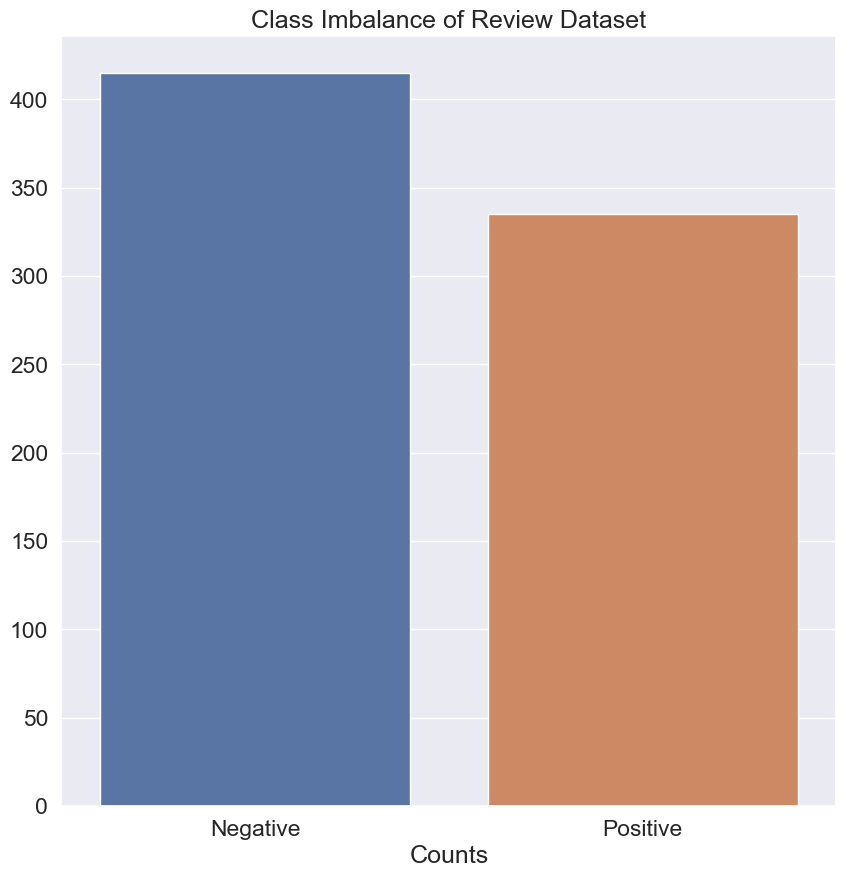

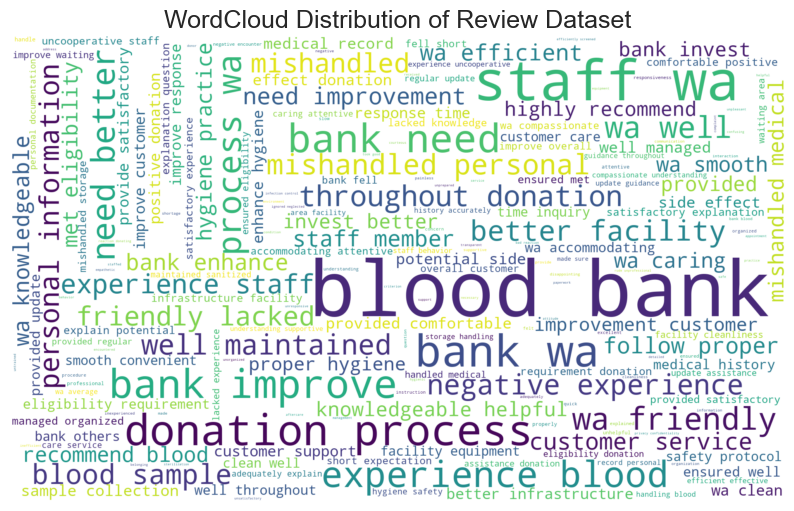

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_inputs (InputLayer)    [(None, 7)]               0         
                                                                 
 embedding (Embedding)       (None, 7, 100)            23200     
                                                                 
 bidirectional_2 (Bidirectio  (None, 7, 512)           549888    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 512)              1182720   
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 64)                4160

In [85]:
class ReviewSentimentAnalysis(object):
    def __init__(self):
        X, Y = retrieve_data()

        self.X = X
        self.Y = Y
        self.max_length = 7
        self.tokenizer_path = 'weights/review sentiment/tokenizer.pkl'
        self.model_weights = 'weights/review sentiment/model.h5'

    def save_load_tokenizer(self):
        if not os.path.exists(self.tokenizer_path):
            tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<oov>')
            tokenizer.fit_on_texts(self.X)
            
            with open(self.tokenizer_path, 'wb') as fp:
                pickle.dump(tokenizer, fp, protocol=pickle.HIGHEST_PROTOCOL)
                
        else:
            with open(self.tokenizer_path, 'rb') as fp:
                tokenizer = pickle.load(fp)
                
        return tokenizer
    
    def handle_data(self):
        tokenizer = self.save_load_tokenizer()
        
        X_seq = tokenizer.texts_to_sequences(self.X) # tokenize train data
        # vis_length_variation(X_seq, self.Y)

        self.X_pad = tf.keras.preprocessing.sequence.pad_sequences(
                                                                    X_seq, 
                                                                    maxlen=self.max_length, 
                                                                    padding='pre', 
                                                                    truncating='pre'
                                                                    )# Pad Train data

        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.word_index) + 1
        
    def classifier(self, embedding_dim = 100): # Building the RNN model
        inputs = tf.keras.layers.Input(shape=(self.max_length,), name='text_inputs')
        x = tf.keras.layers.Embedding(
                                        output_dim = embedding_dim, 
                                        input_dim = self.vocab_size, 
                                        input_length = self.max_length, 
                                        name = 'embedding'
                                        )(inputs) # Embedding layer
        
        x = tf.keras.layers.Bidirectional(
                                        tf.keras.layers.GRU(
                                                            256,
                                                            unroll=True,
                                                            return_sequences = True
                                                            )
                                        )(x)
        x = tf.keras.layers.Bidirectional(
                                        tf.keras.layers.GRU(
                                                            256,
                                                            unroll=True,
                                                            return_sequences = False
                                                            )
                                        )(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dense(64)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        model = tf.keras.models.Model(
                                    inputs=inputs, 
                                    outputs=output
                                    )
        
        model.summary()
        self.model = model

    def train(self):
        self.classifier()
        self.model.compile(
                    loss='binary_crossentropy', 
                    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
                    metrics=[
                            tf.keras.metrics.BinaryAccuracy(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.AUC()
                            ]
                        )
        self.history = self.model.fit(
                                self.X_pad,
                                self.Y,
                                batch_size = 32,
                                epochs = 20,
                                validation_split = 0.15
                                )
        
    def save_model(self):
        self.model.save(self.model_weights)
    
    def loaded_model(self): # Load and compile pretrained model
        self.model = tf.keras.models.load_model(self.model_weights)
        self.model.compile(
                        loss='binary_crossentropy', 
                        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
                        metrics=[
                                tf.keras.metrics.BinaryAccuracy(),
                                tf.keras.metrics.Precision(),
                                tf.keras.metrics.Recall(),
                                tf.keras.metrics.AUC()
                                ]
                        )
        self.model.summary()

    def run(self):
        self.handle_data()
        if os.path.exists(self.model_weights):
            self.loaded_model()
        else:
            self.train()
            self.save_model()

if __name__ == '__main__':
    bot = ReviewSentimentAnalysis()
    bot.run()

KeyError: 'precision_3'

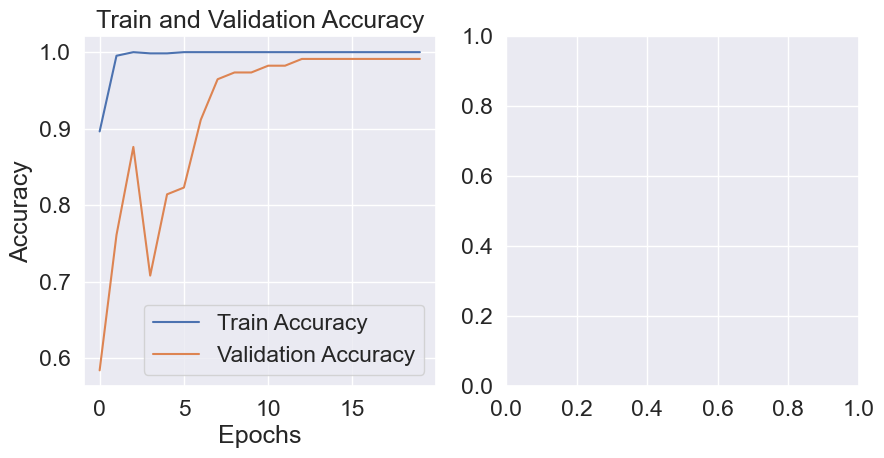

In [86]:
history = bot.history.history

plt.subplot(2,2,1)
plt.plot(history['binary_accuracy'], label='Train Accuracy')
plt.plot(history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history['precision_3'], label='Train Precision')
plt.plot(history['val_precision_3'], label='Validation Precision')
plt.title('Train and Validation Precision') 
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2,2,3)
plt.plot(history['recall_3'], label='Train Recall')
plt.plot(history['val_recall_3'], label='Validation Recall')
plt.title('Train and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2,2,4)
plt.plot(history['auc_3'], label='Train AUC')
plt.plot(history['val_auc_3'], label='Validation AUC')
plt.title('Train and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.savefig('visualization/review_metrics.png')
plt.show()


In [87]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(Y, P, title, save_path, cmap=None, normalize=True):
    cf_matrix = confusion_matrix(Y, P)
    labels = ['NEGATIVE', 'POSITIVE']
    df_confusion = pd.DataFrame(cf_matrix, index = labels, columns=labels)
    df_confusion['TOTAL'] = df_confusion.sum(axis=1)
    df_confusion.loc['TOTAL']= df_confusion.sum()

    # get percentages
    df_percentages = df_confusion.div(df_confusion.TOTAL, axis=0)
    df_percentages.TOTAL = 0

    plt.figure(figsize=(24, 10))
                            
    sns.set(font_scale = 1.5)

    # cmap using data for color, taking values from annot
    ax = sns.heatmap(data=df_percentages, annot=df_confusion, cmap='Blues', fmt="d",
                    cbar_kws={'label': 'percentages'})  
    
    ax.set_title(title,size=22)
    ax.set_xlabel('\nPredicted Values',size=20)
    ax.set_ylabel('Actual Values ', size=20)
    plt.savefig(save_path)
    plt.show()


24/24 [==============================] - 2s 28ms/step


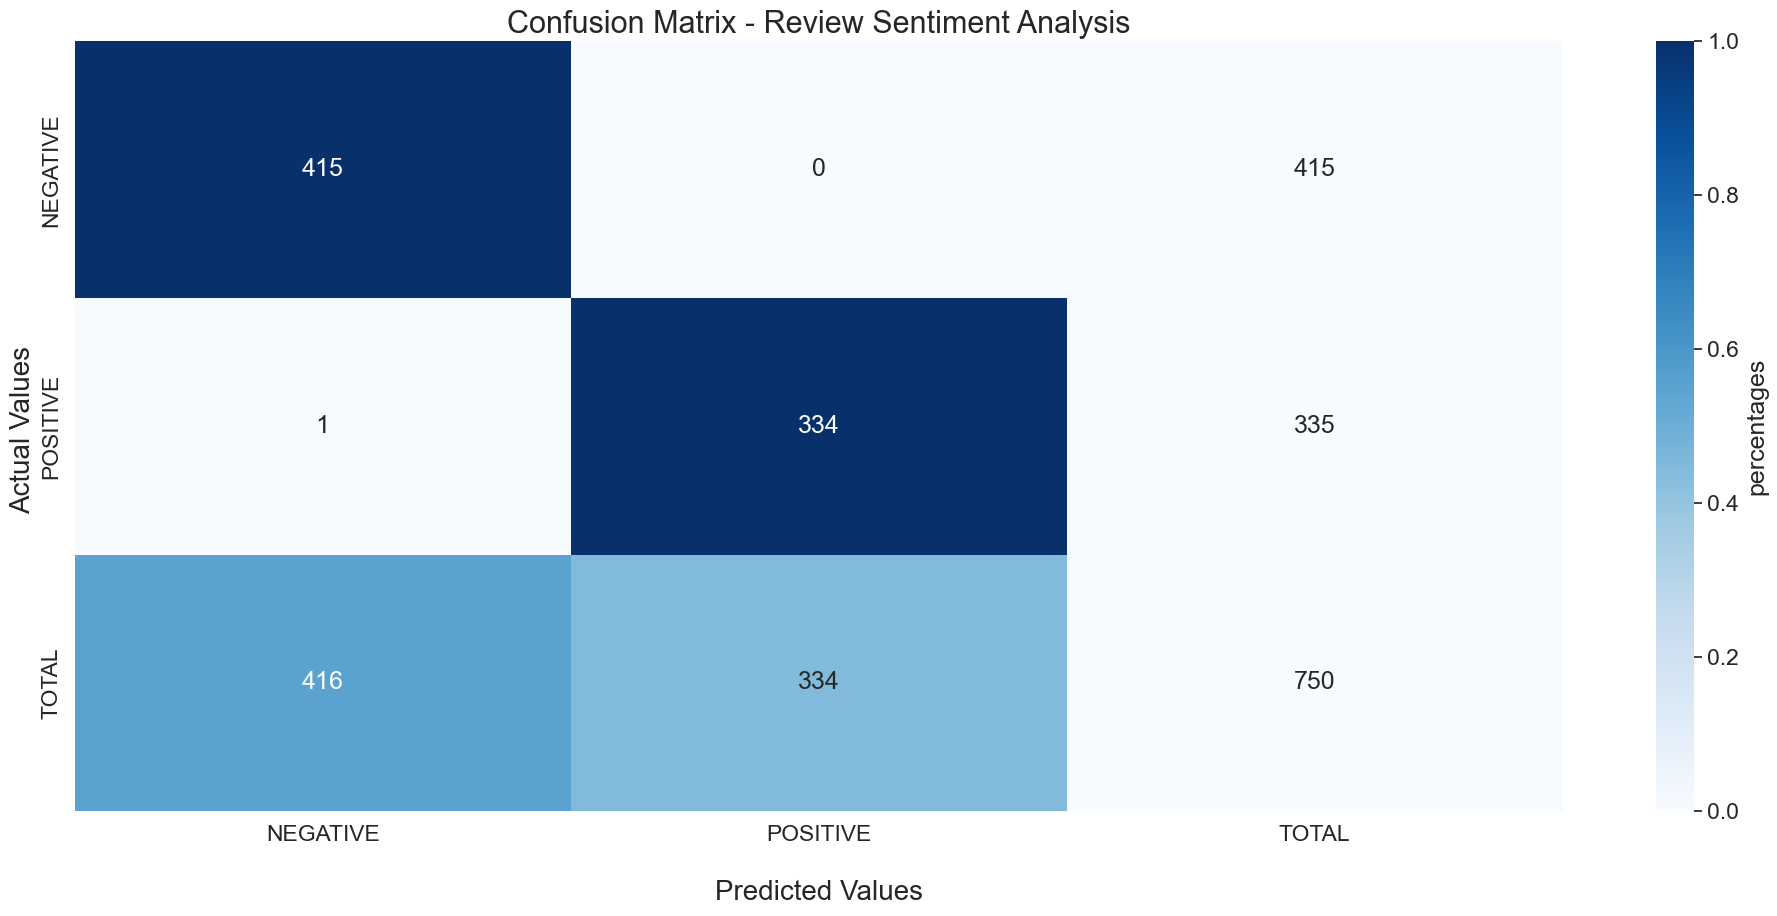

In [88]:
Y = bot.Y
X = bot.X_pad

P = bot.model.predict(X)
P = P.squeeze()
P = np.round(P)

plot_confusion_matrix(
                      Y, P, 
                      'Confusion Matrix - Review Sentiment Analysis', 
                      'visualization/Confusion Matrix - Review Sentiment Analysis.png'
                      )

In [89]:
def sample_inference(review):
    review = preprocessed_data(review)
    review = bot.tokenizer.texts_to_sequences(review)
    review = tf.keras.preprocessing.sequence.pad_sequences(
                                                            review, 
                                                            maxlen=bot.max_length, 
                                                            padding='pre', 
                                                            truncating='pre'
                                                            )
    pred = bot.model.predict(review).squeeze()
    pred = np.round(pred)
    return pred.astype(int)

In [90]:
# def derive_blood_camp_Scores():
#     df_reviews = pd.read_excel(reviews_path, sheet_name='Reviews') 
#     df_reviews['Reviews'] = df_reviews['Reviews'].apply(preprocess_one)
#     df_reviews['SentimentP'] = sample_inference(df_reviews['Reviews'].values)
#     df_reviews = df_reviews[['Camp_Id', 'SentimentP']]
#     df_reviews = df_reviews.groupby('Camp_Id').mean().reset_index()
#     # round to 3 decimal places
#     df_reviews['SentimentP'] = df_reviews['SentimentP'].round(3)
#     df_reviews.to_csv('data/Blood Camp Reviewed.csv', index=False)

# derive_blood_camp_Scores()

# Inference

In [91]:
import re, os 
import pickle  
import numpy as np 
import pandas as pd  
import tensorflow as tf   
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from math import sin, cos, sqrt, atan2, radians, asin

In [92]:
reviews_path = "data/Blood Camp Reviews.xlsx"
reviewed_path = "data/Blood Camp Reviewed.csv"
review_model_weights = 'weights/review sentiment/model.h5'
review_tokenizer_path = 'weights/review sentiment/tokenizer.pkl'

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
stopwords_list = stopwords.words('english')

oov_token = '<OOV>'
pad_token = '<PAD>'

np.random.seed(1234)
tf.random.set_seed(1234)

In [93]:
review_model = tf.keras.models.load_model(review_model_weights)
review_model.compile(
                    loss='binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                    metrics=[
                            tf.keras.metrics.BinaryAccuracy(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.AUC()
                            ]
                    )

with open(review_tokenizer_path, 'rb') as fp:
    review_tokenizer = pickle.load(fp)

In [94]:
def lemmatization(lemmatizer,sentence):
    lem = [lemmatizer.lemmatize(k) for k in sentence]
    return [k for k in lem if k]

def remove_stop_words(stopwords_list,sentence):
    return [k for k in sentence if k not in stopwords_list]

def preprocess_one(review):
    review = review.lower()
    remove_punc = tokenizer.tokenize(review) # Remove puntuations
    remove_num = [re.sub('[0-9]', '', i) for i in remove_punc] # Remove Numbers
    remove_num = [i for i in remove_num if len(i)>0] # Remove empty strings
    lemmatized = lemmatization(lemmatizer,remove_num) # Word Lemmatization
    remove_stop = remove_stop_words(stopwords_list,lemmatized) # remove stop words
    updated_review = ' '.join(remove_stop)
    return updated_review

def preprocessed_data(reviews):
    updated_reviews = []
    if isinstance(reviews, np.ndarray) or isinstance(reviews, list):
        updated_reviews = [preprocess_one(review) for review in reviews]
    elif isinstance(reviews, np.str_)  or isinstance(reviews, str):
        updated_reviews = [preprocess_one(reviews)]

    return np.array(updated_reviews)

def inference_review(review):
    review = preprocessed_data(review)
    review = review_tokenizer.texts_to_sequences(review)
    review = tf.keras.preprocessing.sequence.pad_sequences(
                                                            review, 
                                                            maxlen=7, 
                                                            padding='pre', 
                                                            truncating='pre'
                                                            )
    pred = review_model.predict(review).squeeze()
    pred = np.round(pred)
    return pred.astype(int)

def haversine(p1, p2):
    lat1, lon1 = p1
    lat2, lon2 = p2
    
    lat1 = float(lat1)
    lon1 = float(lon1)
    
    lat2 = float(lat2)
    lon2 = float(lon2)
    
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    
    c = 2 * asin(sqrt(a)) 
    r = 6371 
    distance_km = c * r
    return distance_km

def derive_blood_camps(
                        user_location,
                        max_distance = 10
                        ):
    df_reviews = pd.read_excel(reviews_path, sheet_name='Reviews') 
    df_locations = pd.read_excel(reviews_path, sheet_name='Locations')
    df_reviews['Reviews'] = df_reviews['Reviews'].apply(preprocess_one)
    df_reviews['SentimentP'] = inference_review(df_reviews['Reviews'].values)

    df_reviews = df_reviews[['Camp_Id', 'SentimentP']]
    df_reviews = df_reviews.groupby('Camp_Id').mean().reset_index()
    df_reviews['SentimentP'] = df_reviews['SentimentP'].round(3)

    df = pd.merge(df_reviews, df_locations, on='Camp_Id', how='left')
    df[['Latitude', 'Longitude']] = df.Location.str.split(",", expand=True)
    del df['Location']

    df['Latitude'] = df['Latitude'].str.strip().astype(float)
    df['Longitude'] = df['Longitude'].str.strip().astype(float)
    df['Location'] = df[['Latitude', 'Longitude']].apply(tuple, axis=1)
    del df['Latitude'], df['Longitude']
    
    df['distance'] = df['Location'].apply(
                                            lambda x: haversine(
                                                                user_location,                      
                                                                x
                                                                )
                                        )
    df = df[df['distance'] <= max_distance]
    df = df.sort_values(by=['SentimentP'], ascending=False)
    df = df[['Camp_Id', 'distance']]
    df['distance'] = df['distance'].round(3).astype(str) + ' km'

    response = df.to_dict('records')
    return response

In [95]:
derive_blood_camps((6.920859540782977, 79.86867093270116))

24/24 [==============================] - 2s 27ms/step


[{'Camp_Id': 'C5', 'distance': '0.71 km'},
 {'Camp_Id': 'C3', 'distance': '0.0 km'},
 {'Camp_Id': 'C2', 'distance': '1.511 km'},
 {'Camp_Id': 'C4', 'distance': '0.278 km'},
 {'Camp_Id': 'C1', 'distance': '0.431 km'}]